# EDA: Yelp Academic Dataset

## Objetivos de este Notebook

1. **Cargar y explorar** la estructura de reviews, business y users
2. **Visualizar distribuciones** de ratings, longitud de texto, temporalidad
3. **Analizar reviews ambiguas** (stars == 3) - caso especial del TFM
4. **Prototipar NLP básico**: limpieza de texto, VADER sentiment
5. **Identificar patrones** para informar los tools de la Fase 2
6. **Explorar users**: influencia, elite status, correlación con reviews
7. **NLP**

---

## 1. Setup e Imports

In [1]:
# Imports estandar
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# === DETECCION ROBUSTA DEL PROJECT ROOT ===
# Funciona desde cualquier ubicacion del notebook
def find_project_root() -> Path:
    """Busca la raiz del proyecto (donde esta pyproject.toml)."""
    # Intentar desde el directorio del notebook
    notebook_dir = Path.cwd()
    
    # Buscar hacia arriba pyproject.toml
    for parent in [notebook_dir] + list(notebook_dir.parents):
        if (parent / "pyproject.toml").exists():
            return parent
    
    # Fallback: asumir estructura notebooks/ -> proyecto
    if notebook_dir.name == "notebooks":
        return notebook_dir.parent
    
    return notebook_dir

project_root = find_project_root()
sys.path.insert(0, str(project_root / "src"))

# Analisis de datos
import polars as pl
import pandas as pd
import numpy as np

# Visualizacion
import matplotlib.pyplot as plt
import seaborn as sns

# NLP
import re
from collections import Counter

# Configuracion de visualizacion
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
sns.set_palette('husl')

# Settings del proyecto (ahora con rutas absolutas)
from tfm.config.settings import get_settings, BRONZE_FILES, EDA_SAMPLE_SIZES, PROJECT_ROOT
settings = get_settings()

print(f"Project root: {PROJECT_ROOT}")
print(f"Yelp bronze dir: {settings.yelp_bronze_dir}")
print(f"Es ruta absoluta: {settings.yelp_bronze_dir.is_absolute()}")
print(f"\nArchivos disponibles:")
for name, file in BRONZE_FILES['yelp'].items():
    path = settings.yelp_bronze_dir / file
    exists = "SI EXISTE" if path.exists() else "NO EXISTE"
    print(f"  [{exists}] {name}: {path}")

Project root: C:\Users\Ozkr_\OneDrive - ESCUELA COLOMBIANA DE INGENIERIA JULIO GARAVITO\UAM\TFM\tfm-agents
Yelp bronze dir: C:\Users\Ozkr_\OneDrive - ESCUELA COLOMBIANA DE INGENIERIA JULIO GARAVITO\UAM\TFM\tfm-agents\data\bronze\yelp
Es ruta absoluta: True

Archivos disponibles:
  [SI EXISTE] reviews: C:\Users\Ozkr_\OneDrive - ESCUELA COLOMBIANA DE INGENIERIA JULIO GARAVITO\UAM\TFM\tfm-agents\data\bronze\yelp\yelp_academic_dataset_review.json
  [SI EXISTE] business: C:\Users\Ozkr_\OneDrive - ESCUELA COLOMBIANA DE INGENIERIA JULIO GARAVITO\UAM\TFM\tfm-agents\data\bronze\yelp\yelp_academic_dataset_business.json
  [SI EXISTE] users: C:\Users\Ozkr_\OneDrive - ESCUELA COLOMBIANA DE INGENIERIA JULIO GARAVITO\UAM\TFM\tfm-agents\data\bronze\yelp\yelp_academic_dataset_user.json


## 2. Carga de Datos

Yelp tiene millones de registros. Para EDA usamos un sample manejable.

In [2]:
# Configuración de carga
REVIEW_SAMPLE_SIZE = EDA_SAMPLE_SIZES.get('yelp_reviews', 50_000)
USER_SAMPLE_SIZE = EDA_SAMPLE_SIZES.get('yelp_users', 50_000)

print(f"Cargando sample de {REVIEW_SAMPLE_SIZE:,} reviews...")
print(f"Cargando sample de {USER_SAMPLE_SIZE:,} users...")
print("Cargando todos los business (dataset más pequeño)...")

Cargando sample de 50,000 reviews...
Cargando sample de 50,000 users...
Cargando todos los business (dataset más pequeño)...


In [3]:
# === CARGAR REVIEWS ===
reviews_path = settings.yelp_bronze_dir / BRONZE_FILES['yelp']['reviews']
df_reviews = pl.read_ndjson(reviews_path, n_rows=REVIEW_SAMPLE_SIZE)

print(f"Reviews cargadas: {df_reviews.shape[0]:,} filas, {df_reviews.shape[1]} columnas")
print(f"\nColumnas: {df_reviews.columns}")
print(f"\nTipos de datos:")
for col, dtype in zip(df_reviews.columns, df_reviews.dtypes):
    print(f"  {col}: {dtype}")

Reviews cargadas: 50,000 filas, 9 columnas

Columnas: ['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny', 'cool', 'text', 'date']

Tipos de datos:
  review_id: String
  user_id: String
  business_id: String
  stars: Float64
  useful: Int64
  funny: Int64
  cool: Int64
  text: String
  date: String


In [4]:
# === CARGAR USERS ===
users_path = settings.yelp_bronze_dir / BRONZE_FILES['yelp']['users']
df_users = pl.read_ndjson(users_path, n_rows=USER_SAMPLE_SIZE)

print(f"Users cargados: {df_users.shape[0]:,} filas, {df_users.shape[1]} columnas")
print(f"\nColumnas: {df_users.columns}")

Users cargados: 50,000 filas, 22 columnas

Columnas: ['user_id', 'name', 'review_count', 'yelping_since', 'useful', 'funny', 'cool', 'elite', 'friends', 'fans', 'average_stars', 'compliment_hot', 'compliment_more', 'compliment_profile', 'compliment_cute', 'compliment_list', 'compliment_note', 'compliment_plain', 'compliment_cool', 'compliment_funny', 'compliment_writer', 'compliment_photos']


In [5]:
# === CARGAR BUSINESS ===
business_path = settings.yelp_bronze_dir / BRONZE_FILES['yelp']['business']
df_business = pl.read_ndjson(business_path)

print(f"Business cargados: {df_business.shape[0]:,} filas, {df_business.shape[1]} columnas")
print(f"\nColumnas: {df_business.columns}")

Business cargados: 150,346 filas, 14 columnas

Columnas: ['business_id', 'name', 'address', 'city', 'state', 'postal_code', 'latitude', 'longitude', 'stars', 'review_count', 'is_open', 'attributes', 'categories', 'hours']


In [6]:
# Vista previa de cada dataset
print("REVIEWS:")
df_reviews.head(3)

REVIEWS:


review_id,user_id,business_id,stars,useful,funny,cool,text,date
str,str,str,f64,i64,i64,i64,str,str
"""KU_O5udG6zpxOg-VcAEodg""","""mh_-eMZ6K5RLWhZyISBhwA""","""XQfwVwDr-v0ZS3_CbbE5Xw""",3.0,0,0,0,"""If you decide to eat here, jus…","""2018-07-07 22:09:11"""
"""BiTunyQ73aT9WBnpR9DZGw""","""OyoGAe7OKpv6SyGZT5g77Q""","""7ATYjTIgM3jUlt4UM3IypQ""",5.0,1,0,1,"""I've taken a lot of spin class…","""2012-01-03 15:28:18"""
"""saUsX_uimxRlCVr67Z4Jig""","""8g_iMtfSiwikVnbP2etR0A""","""YjUWPpI6HXG530lwP-fb2A""",3.0,0,0,0,"""Family diner. Had the buffet. …","""2014-02-05 20:30:30"""


In [7]:
print("USERS")
df_users.head(3)

USERS


user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
str,str,i64,str,i64,i64,i64,str,str,i64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
"""qVc8ODYU5SZjKXVBgXdI7w""","""Walker""",585,"""2007-01-25 16:47:26""",7217,1259,5994,"""2007""","""NSCy54eWehBJyZdG2iE84w, pe42u7…",267,3.91,250,65,55,56,18,232,844,467,467,239,180
"""j14WgRoU_-2ZE1aw1dXrJg""","""Daniel""",4333,"""2009-01-25 04:35:42""",43091,13066,27281,"""2009,2010,2011,2012,2013,2014,…","""ueRPE0CX75ePGMqOFVj6IQ, 52oH4D…",3138,3.74,1145,264,184,157,251,1847,7054,3131,3131,1521,1946
"""2WnXYQFK0hXEoTxPtV2zvg""","""Steph""",665,"""2008-07-25 10:41:00""",2086,1010,1003,"""2009,2010,2011,2012,2013""","""LuO3Bn4f3rlhyHIaNfTlnA, j9B4Xd…",52,3.32,89,13,10,17,3,66,96,119,119,35,18


In [8]:
print("BUSINESS:")
df_business.head(3)

BUSINESS:


business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
str,str,str,str,str,str,f64,f64,f64,i64,i64,struct[33],str,struct[7]
"""Pns2l4eNsfO8kk83dixA6A""","""Abby Rappoport, LAC, CMQ""","""1616 Chapala St, Ste 2""","""Santa Barbara""","""CA""","""93101""",34.426679,-119.711197,5.0,7,0,"{null,null,null,null,null,null,null,null,null,null,null,""True"",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null}","""Doctors, Traditional Chinese M…",null
"""mpf3x-BjTdTEA3yCZrAYPw""","""The UPS Store""","""87 Grasso Plaza Shopping Cente…","""Affton""","""MO""","""63123""",38.551126,-90.335695,3.0,15,1,"{null,""True"",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null}","""Shipping Centers, Local Servic…","{""0:0-0:0"",""8:0-18:30"",""8:0-18:30"",""8:0-18:30"",""8:0-18:30"",""8:0-14:0"",null}"
"""tUFrWirKiKi_TAnsVWINQQ""","""Target""","""5255 E Broadway Blvd""","""Tucson""","""AZ""","""85711""",32.223236,-110.880452,3.5,22,0,"{""{'garage': False, 'street': False, 'validated': False, 'lot': True, 'valet': False}"",""True"",null,""False"",""False"",""False"",""False"",null,null,null,""2"",""False"",""False"",""False"",null,null,""False"",""u'no'"",""True"",""False"",""False"",null,""True"",null,null,null,null,null,null,null,null,null,null}","""Department Stores, Shopping, F…","{""8:0-22:0"",""8:0-22:0"",""8:0-22:0"",""8:0-22:0"",""8:0-23:0"",""8:0-23:0"",""8:0-22:0""}"


## 3. Análisis de Reviews

### 3.1 Distribución de Stars (Ratings)

In [9]:
# Distribución de stars
stars_dist = df_reviews.group_by('stars').agg(
    pl.count().alias('count')
).sort('stars')

total = stars_dist['count'].sum()
stars_dist = stars_dist.with_columns(
    (pl.col('count') / total * 100).round(2).alias('percentage')
)

print("Distribución de Stars:")
print(stars_dist)

# Identificar desbalance
pct_positive = stars_dist.filter(pl.col('stars') >= 4)['percentage'].sum()
pct_negative = stars_dist.filter(pl.col('stars') <= 2)['percentage'].sum()
pct_ambiguous = stars_dist.filter(pl.col('stars') == 3)['percentage'].sum()

print(f"\n RESUMEN:")
print(f"  Positivas (4-5): {pct_positive:.1f}%")
print(f"  Negativas (1-2): {pct_negative:.1f}%")
print(f"  Ambiguas (3):    {pct_ambiguous:.1f}%")

Distribución de Stars:
shape: (5, 3)
┌───────┬───────┬────────────┐
│ stars ┆ count ┆ percentage │
│ ---   ┆ ---   ┆ ---        │
│ f64   ┆ u32   ┆ f64        │
╞═══════╪═══════╪════════════╡
│ 1.0   ┆ 5379  ┆ 10.76      │
│ 2.0   ┆ 4003  ┆ 8.01       │
│ 3.0   ┆ 5677  ┆ 11.35      │
│ 4.0   ┆ 12721 ┆ 25.44      │
│ 5.0   ┆ 22220 ┆ 44.44      │
└───────┴───────┴────────────┘

 RESUMEN:
  Positivas (4-5): 69.9%
  Negativas (1-2): 18.8%
  Ambiguas (3):    11.3%


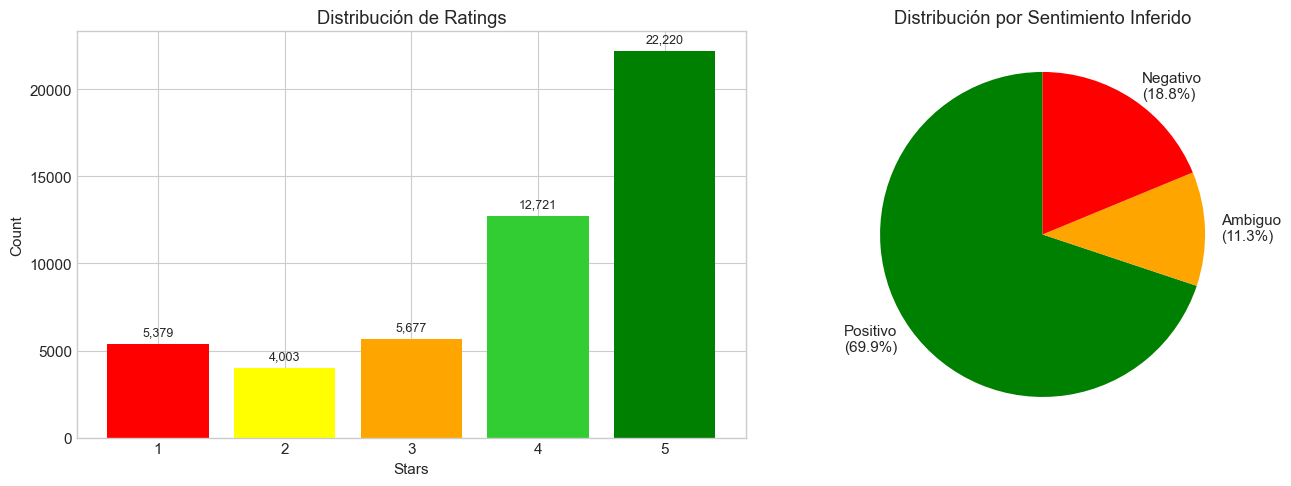

In [20]:
# Visualización de distribucion de stars
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
colors = ['red', 'yellow','orange', 'limegreen', 'green']
stars_pd = stars_dist.to_pandas()
axes[0].bar(stars_pd['stars'], stars_pd['count'], color=colors)
axes[0].set_xlabel('Stars')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribución de Ratings')
for i, (star, count) in enumerate(zip(stars_pd['stars'], stars_pd['count'])):
    axes[0].text(star, count + 500, f'{count:,}', ha='center', fontsize=9)

# Pie chart para los sentimientos
sentiment_data = [pct_positive, pct_ambiguous, pct_negative]
sentiment_labels = [f'Positivo\n({pct_positive:.1f}%)', 
                    f'Ambiguo\n({pct_ambiguous:.1f}%)', 
                    f'Negativo\n({pct_negative:.1f}%)']
sentiment_colors = ['green', 'orange', 'red']
axes[1].pie(sentiment_data, labels=sentiment_labels, colors=sentiment_colors, 
            autopct='', startangle=90)
axes[1].set_title('Distribución por Sentimiento Inferido')

plt.tight_layout()
plt.show()

### 3.2 Análisis de Texto

In [21]:
# Añadir metricas de texto
df_reviews = df_reviews.with_columns([
    pl.col('text').str.len_chars().alias('text_length'),
    pl.col('text').str.split(' ').list.len().alias('word_count'),
    (pl.col('stars') == 3).alias('is_ambiguous'),
])

# Estadisticas de texto
text_stats = df_reviews.select([
    pl.col('text_length').mean().alias('avg_length'),
    pl.col('text_length').median().alias('median_length'),
    pl.col('text_length').min().alias('min_length'),
    pl.col('text_length').max().alias('max_length'),
    pl.col('text_length').std().alias('std_length'),
    pl.col('word_count').mean().alias('avg_words'),
    pl.col('word_count').median().alias('median_words'),
    (pl.col('text_length') < 10).sum().alias('very_short'),
    (pl.col('text_length') == 0).sum().alias('empty'),
])

print("Estadísticas de Texto:")
print(text_stats)

Estadísticas de Texto:
shape: (1, 9)
┌────────────┬───────────────┬────────────┬────────────┬───┬───────────┬──────────────┬────────────┬───────┐
│ avg_length ┆ median_length ┆ min_length ┆ max_length ┆ … ┆ avg_words ┆ median_words ┆ very_short ┆ empty │
│ ---        ┆ ---           ┆ ---        ┆ ---        ┆   ┆ ---       ┆ ---          ┆ ---        ┆ ---   │
│ f64        ┆ f64           ┆ u32        ┆ u32        ┆   ┆ f64       ┆ f64          ┆ u32        ┆ u32   │
╞════════════╪═══════════════╪════════════╪════════════╪═══╪═══════════╪══════════════╪════════════╪═══════╡
│ 546.99218  ┆ 393.0         ┆ 3          ┆ 4997       ┆ … ┆ 101.95896 ┆ 73.0         ┆ 1          ┆ 0     │
└────────────┴───────────────┴────────────┴────────────┴───┴───────────┴──────────────┴────────────┴───────┘


In [22]:
text_stats

avg_length,median_length,min_length,max_length,std_length,avg_words,median_words,very_short,empty
f64,f64,u32,u32,f64,f64,f64,u32,u32
546.99218,393.0,3,4997,499.267814,101.95896,73.0,1,0


In [23]:
# Longitud de texto por stars
text_by_stars = df_reviews.group_by('stars').agg([
    pl.col('text_length').mean().alias('avg_length'),
    pl.col('text_length').median().alias('median_length'),
    pl.col('word_count').mean().alias('avg_words'),
]).sort('stars')

print("\nLongitud de texto por Rating:")
print(text_by_stars)


Longitud de texto por Rating:
shape: (5, 4)
┌───────┬────────────┬───────────────┬────────────┐
│ stars ┆ avg_length ┆ median_length ┆ avg_words  │
│ ---   ┆ ---        ┆ ---           ┆ ---        │
│ f64   ┆ f64        ┆ f64           ┆ f64        │
╞═══════╪════════════╪═══════════════╪════════════╡
│ 1.0   ┆ 679.692322 ┆ 487.0         ┆ 129.217513 │
│ 2.0   ┆ 681.620035 ┆ 516.0         ┆ 128.41369  │
│ 3.0   ┆ 635.768892 ┆ 476.0         ┆ 119.142505 │
│ 4.0   ┆ 562.342898 ┆ 414.0         ┆ 104.477242 │
│ 5.0   ┆ 459.144689 ┆ 329.0         ┆ 84.762376  │
└───────┴────────────┴───────────────┴────────────┘


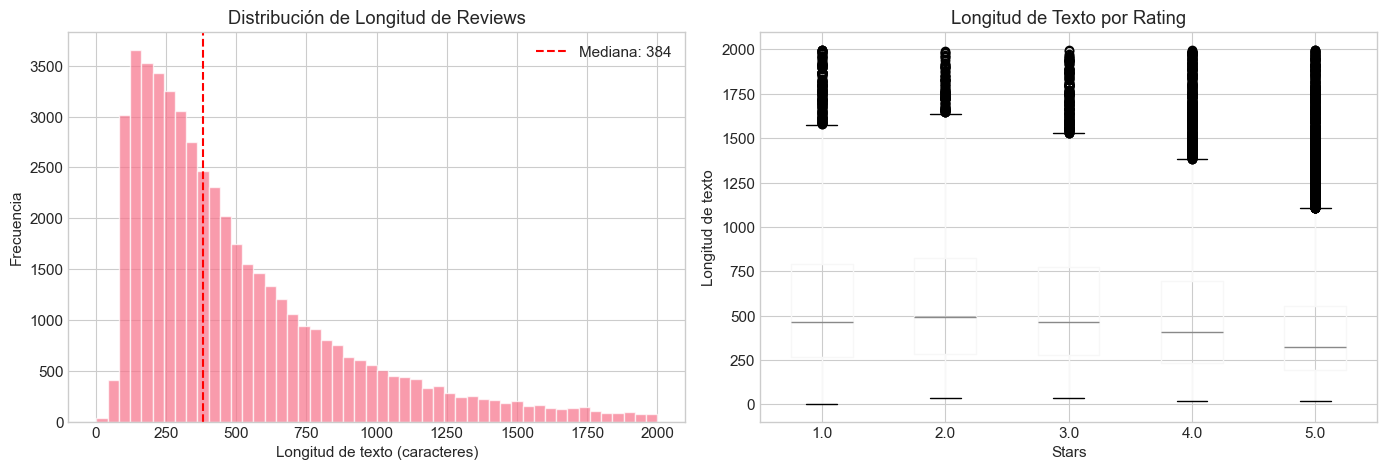

In [24]:
# Visualización de longitud de texto
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histograma de longitud
text_lengths = df_reviews.filter(pl.col('text_length') < 2000)['text_length'].to_numpy()
axes[0].hist(text_lengths, bins=50, edgecolor='white', alpha=0.7)
axes[0].set_xlabel('Longitud de texto (caracteres)')
axes[0].set_ylabel('Frecuencia')
axes[0].set_title('Distribución de Longitud de Reviews')
axes[0].axvline(x=np.median(text_lengths), color='red', linestyle='--', label=f'Mediana: {np.median(text_lengths):.0f}')
axes[0].legend()

# Boxplot por stars
df_box = df_reviews.filter(pl.col('text_length') < 2000).to_pandas()
df_box.boxplot(column='text_length', by='stars', ax=axes[1])
axes[1].set_xlabel('Stars')
axes[1].set_ylabel('Longitud de texto')
axes[1].set_title('Longitud de Texto por Rating')
plt.suptitle('') 

plt.tight_layout()
plt.show()

### 3.3 Análisis Temporal

In [28]:
# Parsear fechas y extraer componentes temporales
df_reviews = df_reviews.with_columns([
    pl.col("date")
      .str.strptime(pl.Datetime, format="%Y-%m-%d %H:%M:%S", strict=False)
      .alias("dt_parsed")
]).with_columns([
    pl.col("dt_parsed").cast(pl.Date).alias("date_parsed"),
    pl.col("dt_parsed").dt.year().alias("year"),
    pl.col("dt_parsed").dt.month().alias("month"),
    pl.col("dt_parsed").dt.weekday().alias("day_of_week"),
])

# Rango de fechas
date_range = df_reviews.select([
    pl.col('date_parsed').min().alias('min_date'),
    pl.col('date_parsed').max().alias('max_date'),
])
print(f"Rango de fechas: {date_range}")

Rango de fechas: shape: (1, 2)
┌────────────┬────────────┐
│ min_date   ┆ max_date   │
│ ---        ┆ ---        │
│ date       ┆ date       │
╞════════════╪════════════╡
│ 2005-03-01 ┆ 2018-10-04 │
└────────────┴────────────┘


In [29]:
# Reviews por año
reviews_by_year = df_reviews.group_by('year').agg([
    pl.count().alias('count'),
    pl.col('stars').mean().alias('avg_stars'),
]).sort('year')

print("Reviews por año:")
print(reviews_by_year)

Reviews por año:
shape: (14, 3)
┌──────┬───────┬───────────┐
│ year ┆ count ┆ avg_stars │
│ ---  ┆ ---   ┆ ---       │
│ i32  ┆ u32   ┆ f64       │
╞══════╪═══════╪═══════════╡
│ 2005 ┆ 56    ┆ 3.982143  │
│ 2006 ┆ 107   ┆ 4.056075  │
│ 2007 ┆ 138   ┆ 3.862319  │
│ 2008 ┆ 555   ┆ 3.834234  │
│ 2009 ┆ 699   ┆ 3.759657  │
│ …    ┆ …     ┆ …         │
│ 2014 ┆ 5807  ┆ 3.785948  │
│ 2015 ┆ 8225  ┆ 3.840608  │
│ 2016 ┆ 8042  ┆ 3.819945  │
│ 2017 ┆ 8604  ┆ 3.916783  │
│ 2018 ┆ 6334  ┆ 3.97695   │
└──────┴───────┴───────────┘


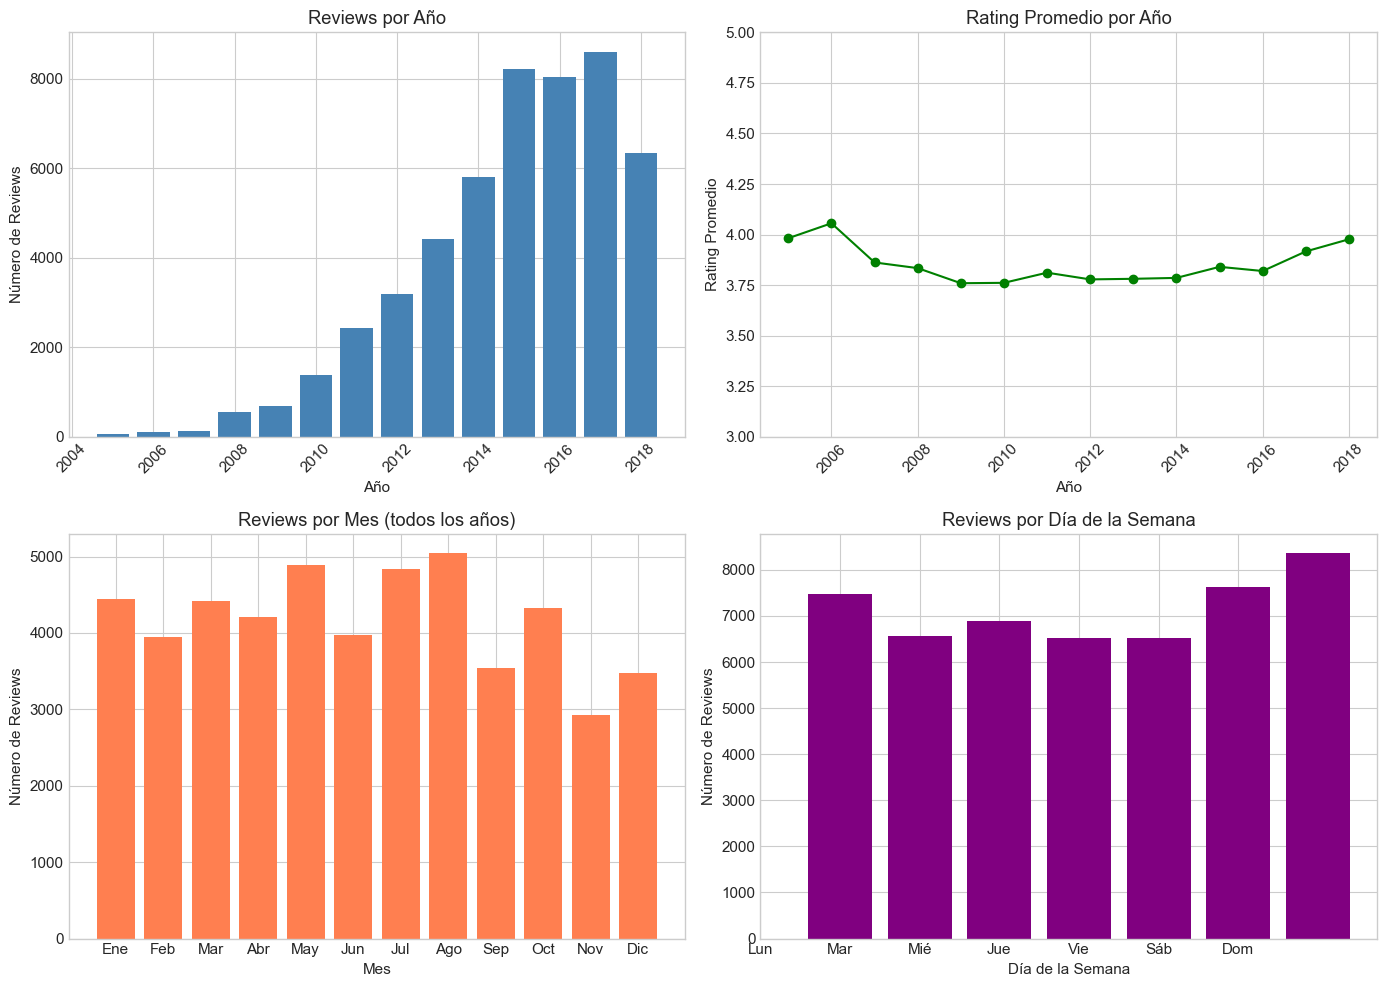

In [30]:
# Visualización temporal
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Reviews por año
year_data = reviews_by_year.to_pandas()
axes[0, 0].bar(year_data['year'], year_data['count'], color='steelblue')
axes[0, 0].set_xlabel('Año')
axes[0, 0].set_ylabel('Número de Reviews')
axes[0, 0].set_title('Reviews por Año')
axes[0, 0].tick_params(axis='x', rotation=45)

# Rating promedio por año
axes[0, 1].plot(year_data['year'], year_data['avg_stars'], marker='o', color='green')
axes[0, 1].set_xlabel('Año')
axes[0, 1].set_ylabel('Rating Promedio')
axes[0, 1].set_title('Rating Promedio por Año')
axes[0, 1].set_ylim(3, 5)
axes[0, 1].tick_params(axis='x', rotation=45)

# Reviews por mes (todos los años)
reviews_by_month = df_reviews.group_by('month').agg(pl.count().alias('count')).sort('month')
month_data = reviews_by_month.to_pandas()
month_names = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']
axes[1, 0].bar(month_data['month'], month_data['count'], color='coral')
axes[1, 0].set_xticks(range(1, 13))
axes[1, 0].set_xticklabels(month_names)
axes[1, 0].set_xlabel('Mes')
axes[1, 0].set_ylabel('Número de Reviews')
axes[1, 0].set_title('Reviews por Mes (todos los años)')

# Reviews por día de la semana
reviews_by_dow = df_reviews.group_by('day_of_week').agg(pl.count().alias('count')).sort('day_of_week')
dow_data = reviews_by_dow.to_pandas()
dow_names = ['Lun', 'Mar', 'Mié', 'Jue', 'Vie', 'Sáb', 'Dom']
axes[1, 1].bar(dow_data['day_of_week'], dow_data['count'], color='purple')
axes[1, 1].set_xticks(range(7))
axes[1, 1].set_xticklabels(dow_names)
axes[1, 1].set_xlabel('Día de la Semana')
axes[1, 1].set_ylabel('Número de Reviews')
axes[1, 1].set_title('Reviews por Día de la Semana')

plt.tight_layout()
plt.show()

### 3.4 Análisis de Reviews Ambiguas (stars == 3)

Este es un caso especial importante para el TFM pues es un grupo importante para aplicar NLP y entender si tienden para el grupo positivo o negativo de las reseñas y como sus features afectan

In [31]:
# Filtrar reviews ambiguas
df_ambiguous = df_reviews.filter(pl.col('is_ambiguous'))
df_not_ambiguous = df_reviews.filter(~pl.col('is_ambiguous'))

print(f"Total reviews: {len(df_reviews):,}")
print(f"Reviews ambiguas (stars=3): {len(df_ambiguous):,} ({len(df_ambiguous)/len(df_reviews)*100:.1f}%)")
print(f"Reviews no ambiguas: {len(df_not_ambiguous):,}")

Total reviews: 50,000
Reviews ambiguas (stars=3): 5,677 (11.4%)
Reviews no ambiguas: 44,323


In [32]:
# Comparar características de reviews ambiguas vs no ambiguas
comparison = pl.concat([
    df_ambiguous.select([
        pl.lit('Ambiguas').alias('grupo'),
        pl.col('text_length').mean().alias('avg_text_length'),
        pl.col('word_count').mean().alias('avg_word_count'),
        pl.col('useful').mean().alias('avg_useful_votes'),
        pl.col('funny').mean().alias('avg_funny_votes'),
        pl.col('cool').mean().alias('avg_cool_votes'),
    ]),
    df_not_ambiguous.select([
        pl.lit('No Ambiguas').alias('grupo'),
        pl.col('text_length').mean().alias('avg_text_length'),
        pl.col('word_count').mean().alias('avg_word_count'),
        pl.col('useful').mean().alias('avg_useful_votes'),
        pl.col('funny').mean().alias('avg_funny_votes'),
        pl.col('cool').mean().alias('avg_cool_votes'),
    ]),
])

print("\nComparación Ambiguas vs No Ambiguas:")
print(comparison)


Comparación Ambiguas vs No Ambiguas:
shape: (2, 6)
┌─────────────┬─────────────────┬────────────────┬──────────────────┬─────────────────┬────────────────┐
│ grupo       ┆ avg_text_length ┆ avg_word_count ┆ avg_useful_votes ┆ avg_funny_votes ┆ avg_cool_votes │
│ ---         ┆ ---             ┆ ---            ┆ ---              ┆ ---             ┆ ---            │
│ str         ┆ f64             ┆ f64            ┆ f64              ┆ f64             ┆ f64            │
╞═════════════╪═════════════════╪════════════════╪══════════════════╪═════════════════╪════════════════╡
│ Ambiguas    ┆ 635.768892      ┆ 119.142505     ┆ 0.80694          ┆ 0.279901        ┆ 0.288885       │
│ No Ambiguas ┆ 535.621438      ┆ 99.758049      ┆ 0.90012          ┆ 0.246667        ┆ 0.352255       │
└─────────────┴─────────────────┴────────────────┴──────────────────┴─────────────────┴────────────────┘


In [34]:
print("EJEMPLOS DE REVIEWS AMBIGUAS (stars=3):")

ambiguous_samples = df_ambiguous.select(['text', 'stars', 'useful']).sample(5, seed=42)
for i, row in enumerate(ambiguous_samples.iter_rows(named=True)):
    print(f"\n--- Review {i+1} (useful votes: {row['useful']}) ---")
    text = row['text'][:500] + "..." if len(row['text']) > 500 else row['text']
    print(text)

EJEMPLOS DE REVIEWS AMBIGUAS (stars=3):

--- Review 1 (useful votes: 0) ---
AVERAGE!

The only way to describe this place.  Had the sirloin steak salad, the meat was over cooked, huge inedible pieces, onions were the same (huge) but raw and not seasoned.  Also had the chicken tacos, which were under seasoned, dry and uninspired (also wayyy to big to eat without a fork).

2 drinks + 2 cheap entrees = $42

Drinks are good though.

2.75 stars

--- Review 2 (useful votes: 0) ---
My wife and I ordered from Copa tonight.

It was surprisingly good. Not great, but good.

I got the coconut shrimp. It was very tasty. It was crispy and flavorful. The dipping sauce was good too, just not enough of it. I enjoyed the pineapple and rice. Although, there could have been more rice.

The chopped salad was decent too. I like the mix of ingredients, especially the jicama.

My wife got the chicken tenders and really liked them.

It's a good bang for you buck type of meal.

--- Review 3 (useful votes: 0) --

## 4. Análisis de Users

In [35]:
# Procesar datos de usuarios
# Primero verificamos si 'friends' es string o lista
print(f"Tipo de 'friends': {df_users['friends'].dtype}")
print(f"Tipo de 'elite': {df_users['elite'].dtype}")

# Procesar según el tipo de datos
if df_users['friends'].dtype == pl.Utf8:
    # friends viene como string separado por comas
    df_users = df_users.with_columns([
        pl.when(pl.col('friends') == 'None')
        .then(0)
        .otherwise(pl.col('friends').str.split(', ').list.len())
        .alias('friends_count'),
    ])
else:
    df_users = df_users.with_columns([
        pl.col('friends').list.len().alias('friends_count'),
    ])

# Procesar elite
if df_users['elite'].dtype == pl.Utf8:
    df_users = df_users.with_columns([
        pl.when(pl.col('elite') == 'None')
        .then(0)
        .otherwise(pl.col('elite').str.split(',').list.len())
        .alias('elite_years_count'),
    ])
    df_users = df_users.with_columns([
        (pl.col('elite_years_count') > 0).alias('is_elite'),
    ])
else:
    df_users = df_users.with_columns([
        pl.col('elite').list.len().alias('elite_years_count'),
        (pl.col('elite').list.len() > 0).alias('is_elite'),
    ])

print(f"\nUsers procesados: {len(df_users):,}")

Tipo de 'friends': String
Tipo de 'elite': String

Users procesados: 50,000


In [51]:
df_users

user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos,friends_count,elite_years_count,is_elite,total_votes_given,total_compliments,influence_score
str,str,i64,str,i64,i64,i64,str,str,i64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,u32,u32,bool,i64,i64,f64
"""qVc8ODYU5SZjKXVBgXdI7w""","""Walker""",585,"""2007-01-25 16:47:26""",7217,1259,5994,"""2007""","""NSCy54eWehBJyZdG2iE84w, pe42u7…",267,3.91,250,65,55,56,18,232,844,467,467,239,180,14995,1,true,14470,2873,0.320106
"""j14WgRoU_-2ZE1aw1dXrJg""","""Daniel""",4333,"""2009-01-25 04:35:42""",43091,13066,27281,"""2009,2010,2011,2012,2013,2014,…","""ueRPE0CX75ePGMqOFVj6IQ, 52oH4D…",3138,3.74,1145,264,184,157,251,1847,7054,3131,3131,1521,1946,4646,14,true,83438,20631,0.406178
"""2WnXYQFK0hXEoTxPtV2zvg""","""Steph""",665,"""2008-07-25 10:41:00""",2086,1010,1003,"""2009,2010,2011,2012,2013""","""LuO3Bn4f3rlhyHIaNfTlnA, j9B4Xd…",52,3.32,89,13,10,17,3,66,96,119,119,35,18,381,5,true,4099,585,0.212826
"""SZDeASXq7o05mMNLshsdIA""","""Gwen""",224,"""2005-11-29 04:38:33""",512,330,299,"""2009,2010,2011""","""enx1vVPnfdNUdPho6PH_wg, 4wOcvM…",28,4.27,24,4,1,6,2,12,16,26,26,10,9,131,3,true,1141,136,0.204441
"""hA5lMy-EnncsH4JoR-hFGQ""","""Karen""",79,"""2007-01-05 19:40:59""",29,15,7,"""""","""PBK4q9KEEBHhFvSXCUirIw, 3FWPpM…",1,3.54,1,1,0,0,0,1,1,0,0,0,0,27,1,true,51,4,0.201118
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""K_sPBSw9NXANtRDnzj3L3A""","""Melody""",9,"""2015-08-04 18:57:30""",25,6,19,"""""","""7SqoEgw5E9VEG3S-ZqkFLw, ZqiYF-…",0,4.22,5,0,0,0,0,0,1,2,2,1,0,625,1,true,50,11,0.204298
"""a4m4ZwQu_0zsJhTrAHBsdA""","""Chris""",428,"""2014-01-17 03:32:21""",2609,758,1973,"""2017,2018,2019,20,20,2021""","""xGkFsFetNPw1ttCLBu4OKA, NHbBrB…",75,4.27,29,10,3,0,0,78,124,106,106,93,34,658,6,true,5340,583,0.212508
"""vnJyZJ2GGZkGYtGABHqRVg""","""Alyssa""",16,"""2014-07-18 20:51:17""",3,3,1,"""""","""KRcKfzPyUlP4NbkNf4vgXg, MJxnyv…",1,4.19,0,0,0,0,0,0,0,0,0,0,2,242,1,true,7,2,0.201826


In [52]:
# Normalizar columnas string
df_users = df_users.with_columns([
    pl.col("friends").cast(pl.Utf8).fill_null("").str.strip_chars().alias("friends_norm"),
    pl.col("elite").cast(pl.Utf8).fill_null("").str.strip_chars().alias("elite_norm"),
])

df_users = df_users.with_columns([
    pl.when(
        (pl.col("friends_norm") == "") |
        (pl.col("friends_norm").str.to_lowercase() == "none")
    )
    .then(0)
    .otherwise(
        pl.col("friends_norm")
          .str.replace_all(r"\s*,\s*", ",", literal=False)  # normaliza "a, b" -> "a,b"
          .str.split(",")
          .list.len()
    )
    .alias("friends_count")
])

df_users = df_users.with_columns([
    pl.col("elite_norm")
      .str.extract_all(r"\d{4}")
      .list.len()
      .alias("elite_years_count"),
]).with_columns([
    (pl.col("elite_years_count") > 0).alias("is_elite"),
])

print(f"Users procesados: {df_users.height:,}")

# Validación rápida
check_elite = df_users.select([
    pl.len().alias("n"),
    (pl.col("elite_norm") == "").sum().alias("elite_empty_string"),
    pl.col("is_elite").mean().alias("pct_elite"),
    pl.col("elite_years_count").max().alias("max_elite_years_count"),
])
print(check_elite)

Users procesados: 50,000
shape: (1, 4)
┌───────┬────────────────────┬───────────┬───────────────────────┐
│ n     ┆ elite_empty_string ┆ pct_elite ┆ max_elite_years_count │
│ ---   ┆ ---                ┆ ---       ┆ ---                   │
│ u32   ┆ u32                ┆ f64       ┆ u32                   │
╞═══════╪════════════════════╪═══════════╪═══════════════════════╡
│ 50000 ┆ 36953              ┆ 0.26084   ┆ 15                    │
└───────┴────────────────────┴───────────┴───────────────────────┘


In [53]:
# Calcular metricas adicionales de usuarios
df_users = df_users.with_columns([
    # Total votos dados
    (pl.col('useful') + pl.col('funny') + pl.col('cool')).alias('total_votes_given'),
    # Total compliments recibidos
    (pl.col('compliment_hot') + pl.col('compliment_more') + pl.col('compliment_profile') +
     pl.col('compliment_cute') + pl.col('compliment_list') + pl.col('compliment_note') +
     pl.col('compliment_plain') + pl.col('compliment_cool') + pl.col('compliment_funny') +
     pl.col('compliment_writer') + pl.col('compliment_photos')).alias('total_compliments'),
])

# Estadisticass de usuarios
user_stats = df_users.select([
    pl.col('review_count').mean().alias('avg_reviews'),
    pl.col('review_count').median().alias('median_reviews'),
    pl.col('review_count').max().alias('max_reviews'),
    pl.col('friends_count').mean().alias('avg_friends'),
    pl.col('fans').mean().alias('avg_fans'),
    pl.col('is_elite').mean().alias('pct_elite'),
    pl.col('average_stars').mean().alias('avg_avg_stars'),
    pl.col('total_compliments').mean().alias('avg_compliments'),
])

print("Estadísticas de Usuarios:")
print(user_stats)

Estadísticas de Usuarios:
shape: (1, 8)
┌─────────────┬────────────────┬─────────────┬─────────────┬──────────┬───────────┬───────────────┬─────────────────┐
│ avg_reviews ┆ median_reviews ┆ max_reviews ┆ avg_friends ┆ avg_fans ┆ pct_elite ┆ avg_avg_stars ┆ avg_compliments │
│ ---         ┆ ---            ┆ ---         ┆ ---         ┆ ---      ┆ ---       ┆ ---           ┆ ---             │
│ f64         ┆ f64            ┆ i64         ┆ f64         ┆ f64      ┆ f64       ┆ f64           ┆ f64             │
╞═════════════╪════════════════╪═════════════╪═════════════╪══════════╪═══════════╪═══════════════╪═════════════════╡
│ 133.45812   ┆ 41.0           ┆ 17473       ┆ 147.32446   ┆ 12.08774 ┆ 0.26084   ┆ 3.845669      ┆ 137.2732        │
└─────────────┴────────────────┴─────────────┴─────────────┴──────────┴───────────┴───────────────┴─────────────────┘


In [54]:
# Comparar Elite vs No Elite
elite_comparison = df_users.group_by('is_elite').agg([
    pl.count().alias('count'),
    pl.col('review_count').mean().alias('avg_reviews'),
    pl.col('friends_count').mean().alias('avg_friends'),
    pl.col('fans').mean().alias('avg_fans'),
    pl.col('average_stars').mean().alias('avg_rating'),
    pl.col('total_compliments').mean().alias('avg_compliments'),
])

print("\nComparación Elite vs No Elite:")
print(elite_comparison)


Comparación Elite vs No Elite:
shape: (2, 7)
┌──────────┬───────┬─────────────┬─────────────┬───────────┬────────────┬─────────────────┐
│ is_elite ┆ count ┆ avg_reviews ┆ avg_friends ┆ avg_fans  ┆ avg_rating ┆ avg_compliments │
│ ---      ┆ ---   ┆ ---         ┆ ---         ┆ ---       ┆ ---        ┆ ---             │
│ bool     ┆ u32   ┆ f64         ┆ f64         ┆ f64       ┆ f64        ┆ f64             │
╞══════════╪═══════╪═════════════╪═════════════╪═══════════╪════════════╪═════════════════╡
│ true     ┆ 13042 ┆ 369.305858  ┆ 308.011348  ┆ 39.837832 ┆ 3.848749   ┆ 482.329244      │
│ false    ┆ 36958 ┆ 50.230505   ┆ 90.620136   ┆ 2.295092  ┆ 3.844582   ┆ 15.507387       │
└──────────┴───────┴─────────────┴─────────────┴───────────┴────────────┴─────────────────┘


In [50]:
df_users.select([
    pl.len().alias("n"),
    pl.col("elite").is_null().sum().alias("elite_nulls"),
    (pl.col("elite") == "None").sum().alias("elite_eq_None"),
    (pl.col("elite").str.strip_chars() == "").sum().alias("elite_empty_string"),
    (pl.col("elite").str.strip_chars() == "[]").sum().alias("elite_eq_empty_list_str"),
    pl.col("elite").unique().head(20).alias("elite_samples")
])


n,elite_nulls,elite_eq_None,elite_empty_string,elite_eq_empty_list_str,elite_samples
u32,u32,u32,u32,u32,str
50000,0,0,36953,0,"""2011,2012,2013,2014,2015,2016,…"
50000,0,0,36953,0,"""2009,2010,2011,2012,2013,2015,…"
50000,0,0,36953,0,"""2011,2012,2014,2015,2016,2017,…"
50000,0,0,36953,0,"""2009,2010,2011,2012,2013,2014,…"
50000,0,0,36953,0,"""2012,2016,2017,2018,2019,20,20…"
…,…,…,…,…,…
50000,0,0,36953,0,"""2014,2015,2016"""
50000,0,0,36953,0,"""2012,2013,2015,2016,2017,2018,…"
50000,0,0,36953,0,"""2016,2018,2019"""


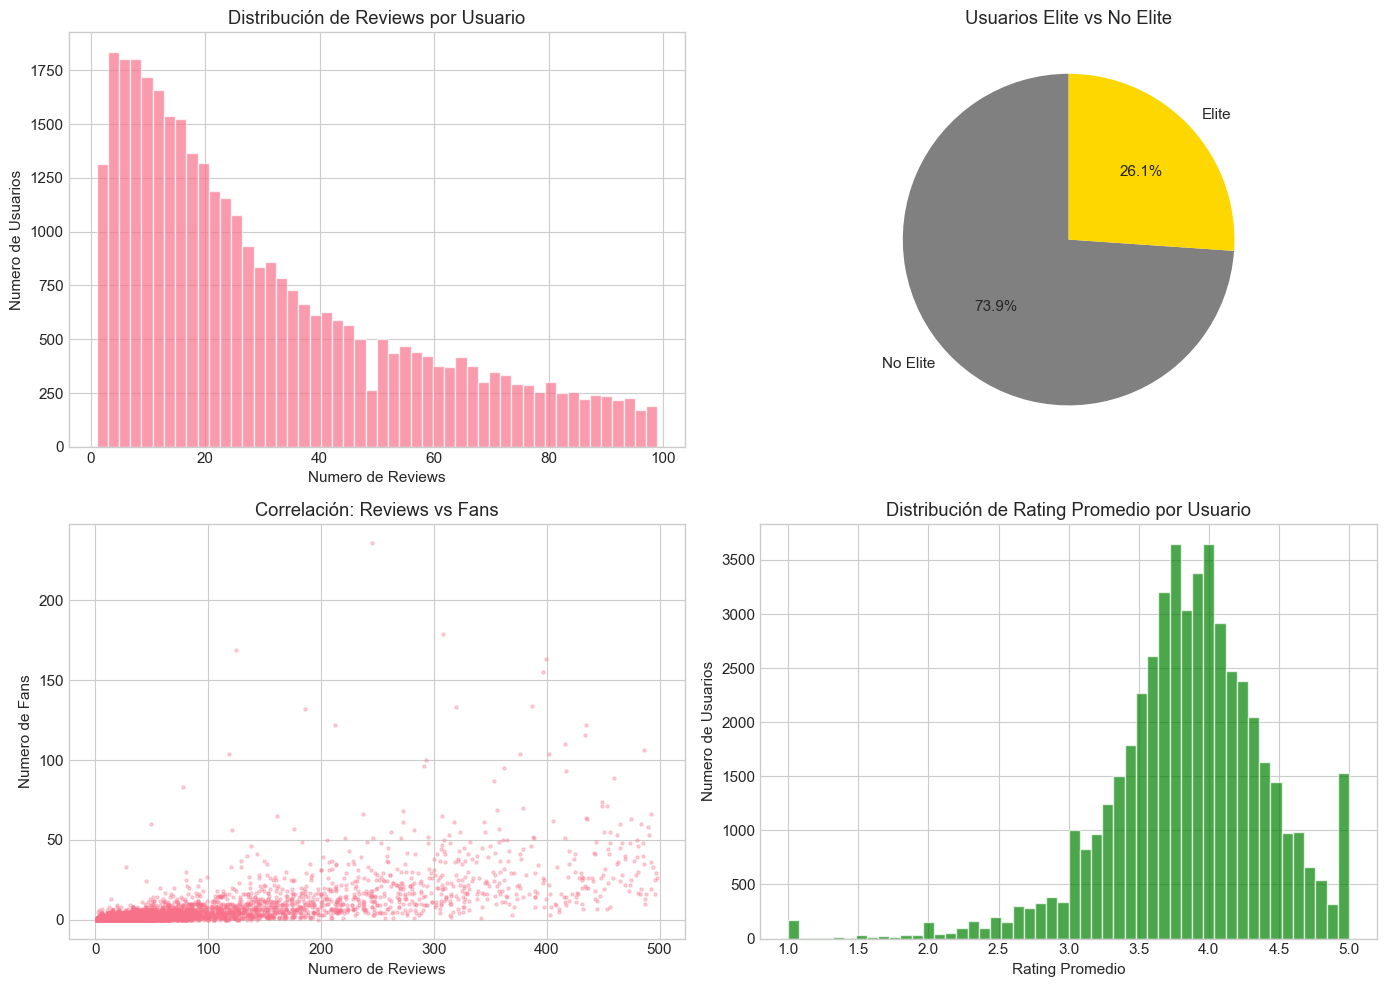

In [55]:
# Visualización de usuarios
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Distribución de reviews por usuario
review_counts = (
    df_users
    .filter(pl.col('review_count') < 100)
    .get_column('review_count')
    .to_numpy()
)

axes[0, 0].hist(review_counts, bins=50, edgecolor='white', alpha=0.7)
axes[0, 0].set_xlabel('Numero de Reviews')
axes[0, 0].set_ylabel('Numero de Usuarios')
axes[0, 0].set_title('Distribución de Reviews por Usuario')

# Elite vs No Elite (pie chart)
elite_data = elite_comparison.select(["is_elite", "count"]).to_pandas()
counts_map = dict(zip(elite_data["is_elite"], elite_data["count"]))

no_elite = counts_map.get(False, 0)
elite = counts_map.get(True, 0)

elite_counts = [no_elite, elite]

axes[0, 1].pie(
    elite_counts,
    labels=['No Elite', 'Elite'],
    colors=['gray', 'gold'],
    autopct='%1.1f%%',
    startangle=90
)
axes[0, 1].set_title('Usuarios Elite vs No Elite')

# Correlación fans vs reviews
filtered_users = df_users.filter(
    (pl.col('review_count') < 500) & (pl.col('fans') < 500)
)

n = min(5000, filtered_users.height)  # importante: usar height del filtrado
sample_users = filtered_users.sample(n=n, seed=42).to_pandas()

axes[1, 0].scatter(sample_users['review_count'], sample_users['fans'], alpha=0.3, s=5)
axes[1, 0].set_xlabel('Numero de Reviews')
axes[1, 0].set_ylabel('Numero de Fans')
axes[1, 0].set_title('Correlación: Reviews vs Fans')

# Distribución de rating promedio
avg_stars = df_users.get_column('average_stars').to_numpy()

axes[1, 1].hist(avg_stars, bins=50, edgecolor='white', alpha=0.7, color='green')
axes[1, 1].set_xlabel('Rating Promedio')
axes[1, 1].set_ylabel('Numero de Usuarios')
axes[1, 1].set_title('Distribución de Rating Promedio por Usuario')

plt.tight_layout()
plt.show()

### 4.1 Score de Influencia de Usuario

Creamos un score que puede usarse como feature para ponderar reviews.

In [56]:
# Calcular score de influencia (normalizado 0-1)
# Basado en: fans, compliments, elite status, review_count, friends

# Primero obtenemos los máximos para normalizar
max_values = df_users.select([
    pl.col('fans').max().alias('max_fans'),
    pl.col('total_compliments').max().alias('max_compliments'),
    pl.col('review_count').max().alias('max_reviews'),
    pl.col('friends_count').max().alias('max_friends'),
]).row(0)

max_fans, max_compliments, max_reviews, max_friends = max_values

# Evitar división por cero
max_fans = max(max_fans, 1)
max_compliments = max(max_compliments, 1)
max_reviews = max(max_reviews, 1)
max_friends = max(max_friends, 1)

# Calcular score de influencia
df_users = df_users.with_columns([
    (
        (pl.col('fans') / max_fans * 0.3) +  # 30% peso fans
        (pl.col('total_compliments') / max_compliments * 0.2) +  # 20% peso compliments
        (pl.col('review_count') / max_reviews * 0.2) +  # 20% peso reviews
        (pl.col('friends_count') / max_friends * 0.1) +  # 10% peso amigos
        (pl.col('is_elite').cast(pl.Float64) * 0.2)  # 20% peso elite
    ).alias('influence_score')
])

# Estadísticas del score
influence_stats = df_users.select([
    pl.col('influence_score').mean().alias('mean'),
    pl.col('influence_score').median().alias('median'),
    pl.col('influence_score').std().alias('std'),
    pl.col('influence_score').quantile(0.9).alias('p90'),
    pl.col('influence_score').quantile(0.99).alias('p99'),
])

print("Estadísticas del Score de Influencia:")
print(influence_stats)

Estadísticas del Score de Influencia:
shape: (1, 5)
┌──────────┬──────────┬──────────┬──────────┬─────────┐
│ mean     ┆ median   ┆ std      ┆ p90      ┆ p99     │
│ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---     │
│ f64      ┆ f64      ┆ f64      ┆ f64      ┆ f64     │
╞══════════╪══════════╪══════════╪══════════╪═════════╡
│ 0.055303 ┆ 0.001185 ┆ 0.091301 ┆ 0.205991 ┆ 0.23034 │
└──────────┴──────────┴──────────┴──────────┴─────────┘


In [57]:
# Top 10 usuarios más influyentes
top_influencers = df_users.sort('influence_score', descending=True).head(10)
print("\nTop 10 Usuarios Más Influyentes:")
print(top_influencers.select(['name', 'review_count', 'fans', 'is_elite', 'elite_years_count', 'influence_score']))


Top 10 Usuarios Más Influyentes:
shape: (10, 6)
┌─────────┬──────────────┬───────┬──────────┬───────────────────┬─────────────────┐
│ name    ┆ review_count ┆ fans  ┆ is_elite ┆ elite_years_count ┆ influence_score │
│ ---     ┆ ---          ┆ ---   ┆ ---      ┆ ---               ┆ ---             │
│ str     ┆ i64          ┆ i64   ┆ bool     ┆ u32               ┆ f64             │
╞═════════╪══════════════╪═══════╪══════════╪═══════════════════╪═════════════════╡
│ Fox     ┆ 17473        ┆ 3493  ┆ true     ┆ 7                 ┆ 0.604838        │
│ Mike    ┆ 1882         ┆ 12497 ┆ true     ┆ 9                 ┆ 0.574563        │
│ Bruce   ┆ 16567        ┆ 867   ┆ true     ┆ 11                ┆ 0.510819        │
│ Michael ┆ 3133         ┆ 1563  ┆ true     ┆ 11                ┆ 0.492345        │
│ Jessica ┆ 2101         ┆ 2627  ┆ true     ┆ 15                ┆ 0.444071        │
│ Anthony ┆ 2741         ┆ 1021  ┆ true     ┆ 9                 ┆ 0.443393        │
│ Toni    ┆ 2704         ┆ 

## 5. Análisis de Business

In [59]:
df_business.head()

business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,categories_list
str,str,str,str,str,str,f64,f64,f64,i64,i64,struct[33],str,struct[7],list[str]
"""Pns2l4eNsfO8kk83dixA6A""","""Abby Rappoport, LAC, CMQ""","""1616 Chapala St, Ste 2""","""Santa Barbara""","""CA""","""93101""",34.426679,-119.711197,5.0,7,0,"{null,null,null,null,null,null,null,null,null,null,null,""True"",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null}","""Doctors, Traditional Chinese M…",null,"[""Doctors"", ""Traditional Chinese Medicine"", … ""Nutritionists""]"
"""mpf3x-BjTdTEA3yCZrAYPw""","""The UPS Store""","""87 Grasso Plaza Shopping Cente…","""Affton""","""MO""","""63123""",38.551126,-90.335695,3.0,15,1,"{null,""True"",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null}","""Shipping Centers, Local Servic…","{""0:0-0:0"",""8:0-18:30"",""8:0-18:30"",""8:0-18:30"",""8:0-18:30"",""8:0-14:0"",null}","[""Shipping Centers"", ""Local Services"", … ""Printing Services""]"
"""tUFrWirKiKi_TAnsVWINQQ""","""Target""","""5255 E Broadway Blvd""","""Tucson""","""AZ""","""85711""",32.223236,-110.880452,3.5,22,0,"{""{'garage': False, 'street': False, 'validated': False, 'lot': True, 'valet': False}"",""True"",null,""False"",""False"",""False"",""False"",null,null,null,""2"",""False"",""False"",""False"",null,null,""False"",""u'no'"",""True"",""False"",""False"",null,""True"",null,null,null,null,null,null,null,null,null,null}","""Department Stores, Shopping, F…","{""8:0-22:0"",""8:0-22:0"",""8:0-22:0"",""8:0-22:0"",""8:0-23:0"",""8:0-23:0"",""8:0-22:0""}","[""Department Stores"", ""Shopping"", … ""Furniture Stores""]"
"""MTSW4McQd7CbVtyjqoe9mw""","""St Honore Pastries""","""935 Race St""","""Philadelphia""","""PA""","""19107""",39.955505,-75.155564,4.0,80,1,"{""{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False}"",""False"",null,""False"",null,""True"",""True"",""u'none'"",null,null,""1"",""False"",null,null,null,null,""False"",""u'free'"",null,null,null,null,""True"",null,null,null,null,null,null,null,null,null,null}","""Restaurants, Food, Bubble Tea,…","{""7:0-20:0"",""7:0-20:0"",""7:0-20:0"",""7:0-20:0"",""7:0-21:0"",""7:0-21:0"",""7:0-21:0""}","[""Restaurants"", ""Food"", … ""Bakeries""]"
"""mWMc6_wTdE0EUBKIGXDVfA""","""Perkiomen Valley Brewery""","""101 Walnut St""","""Green Lane""","""PA""","""18054""",40.338183,-75.471659,4.5,13,1,"{""{'garage': None, 'street': None, 'validated': None, 'lot': True, 'valet': False}"",""True"",null,null,null,""False"",""True"",null,null,""True"",null,null,null,null,null,null,null,null,""True"",null,null,null,""True"",null,null,null,null,null,null,null,null,null,null}","""Brewpubs, Breweries, Food""","{null,null,""14:0-22:0"",""16:0-22:0"",""12:0-22:0"",""12:0-22:0"",""12:0-18:0""}","[""Brewpubs"", ""Breweries"", ""Food""]"


In [61]:
df_business.columns

['business_id',
 'name',
 'address',
 'city',
 'state',
 'postal_code',
 'latitude',
 'longitude',
 'stars',
 'review_count',
 'is_open',
 'attributes',
 'categories',
 'hours',
 'categories_list']

In [44]:
# Analizar categorías de negocios
df_business = df_business.with_columns([
    pl.col('categories').str.split(', ').alias('categories_list')
])

# Explotar categorías y contar
all_categories = df_business.select(
    pl.col('categories_list').explode().alias('category')
).drop_nulls()

category_counts = all_categories.group_by('category').agg(
    pl.count().alias('count')
).sort('count', descending=True)

print(f"Total categorías únicas: {len(category_counts):,}")
print("\nTop 20 Categorías:")
print(category_counts.head(20))

Total categorías únicas: 1,311

Top 20 Categorías:
shape: (20, 2)
┌────────────────────┬───────┐
│ category           ┆ count │
│ ---                ┆ ---   │
│ str                ┆ u32   │
╞════════════════════╪═══════╡
│ Restaurants        ┆ 52268 │
│ Food               ┆ 27781 │
│ Shopping           ┆ 24395 │
│ Home Services      ┆ 14356 │
│ Beauty & Spas      ┆ 14292 │
│ …                  ┆ …     │
│ Coffee & Tea       ┆ 6703  │
│ Fast Food          ┆ 6472  │
│ Breakfast & Brunch ┆ 6239  │
│ American (New)     ┆ 6097  │
│ Hotels & Travel    ┆ 5857  │
└────────────────────┴───────┘


In [65]:
quality = df_business.select([
    pl.len().alias("n"),
    pl.col("business_id").n_unique().alias("business_id_unique"),
    pl.col("name").is_null().sum().alias("name_nulls"),
    pl.col("address").is_null().sum().alias("address_nulls"),
    pl.col("city").is_null().sum().alias("city_nulls"),
    pl.col("state").is_null().sum().alias("state_nulls"),
    pl.col("postal_code").is_null().sum().alias("postal_code_nulls"),
    pl.col("latitude").is_null().sum().alias("latitude_nulls"),
    pl.col("longitude").is_null().sum().alias("longitude_nulls"),
    pl.col("stars").is_null().sum().alias("stars_nulls"),
    pl.col("review_count").is_null().sum().alias("review_count_nulls"),
    pl.col("is_open").is_null().sum().alias("is_open_nulls"),
    pl.col("categories").is_null().sum().alias("categories_nulls"),
    pl.col("hours").is_null().sum().alias("hours_nulls"),
    pl.col("attributes").is_null().sum().alias("attributes_nulls"),
])

coverage = quality.with_columns([
    (1 - pl.col("name_nulls") / n).alias("name_coverage"),
    (1 - pl.col("city_nulls") / n).alias("city_coverage"),
    (1 - pl.col("state_nulls") / n).alias("state_coverage"),
    (1 - pl.col("stars_nulls") / n).alias("stars_coverage"),
    (1 - pl.col("review_count_nulls") / n).alias("review_count_coverage"),
    (1 - pl.col("categories_nulls") / n).alias("categories_coverage"),
    (1 - pl.col("hours_nulls") / n).alias("hours_coverage"),
    (1 - pl.col("attributes_nulls") / n).alias("attributes_coverage"),
])

coverage

n,business_id_unique,name_nulls,address_nulls,city_nulls,state_nulls,postal_code_nulls,latitude_nulls,longitude_nulls,stars_nulls,review_count_nulls,is_open_nulls,categories_nulls,hours_nulls,attributes_nulls,name_coverage,city_coverage,state_coverage,stars_coverage,review_count_coverage,categories_coverage,hours_coverage,attributes_coverage
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,f64,f64,f64,f64,f64,f64,f64,f64
150346,150346,0,0,0,0,0,0,0,0,0,0,103,23223,13744,1.0,1.0,1.0,1.0,1.0,0.9794,-3.6446,-1.7488


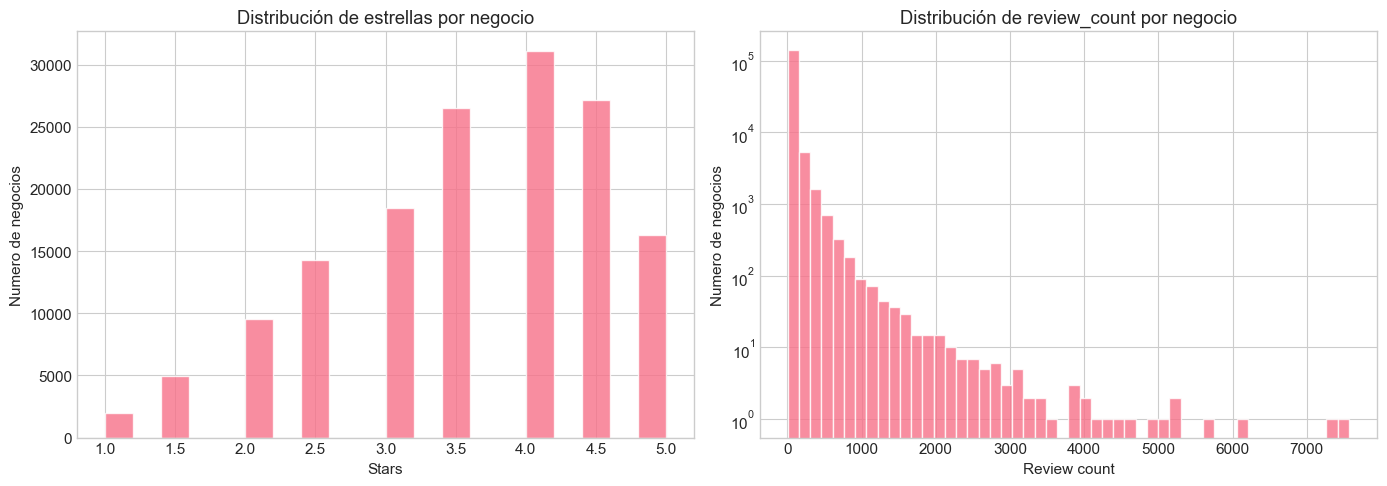

In [67]:
stars = df_business.select(pl.col("stars").drop_nulls()).to_series().to_numpy()
review_count = df_business.select(pl.col("review_count").drop_nulls()).to_series().to_numpy()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(stars, bins=20, edgecolor="white", alpha=0.8)
axes[0].set_title("Distribución de estrellas por negocio")
axes[0].set_xlabel("Stars")
axes[0].set_ylabel("Numero de negocios")

axes[1].hist(review_count, bins=50, edgecolor="white", alpha=0.8)
axes[1].set_title("Distribución de review_count por negocio")
axes[1].set_xlabel("Review count")
axes[1].set_ylabel("Numero de negocios")
axes[1].set_yscale("log")

plt.tight_layout()
plt.show()

shape: (2, 2)
┌─────────┬────────┐
│ is_open ┆ len    │
│ ---     ┆ ---    │
│ i64     ┆ u32    │
╞═════════╪════════╡
│ 0       ┆ 30648  │
│ 1       ┆ 119698 │
└─────────┴────────┘


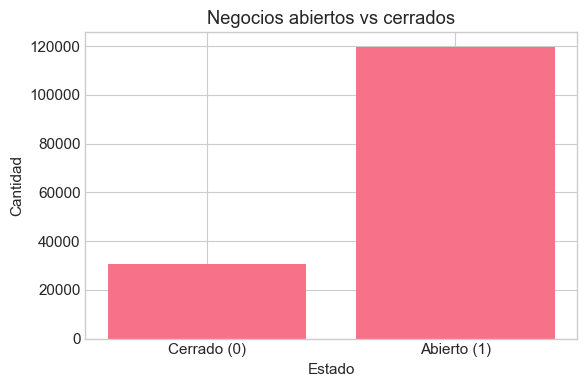

In [68]:
# Estado is_open
open_counts = (
    df_business
    .select(pl.col("is_open").cast(pl.Int64).alias("is_open"))
    .group_by("is_open")
    .len()
    .sort("is_open")
)

print(open_counts)

labels = ["Cerrado (0)", "Abierto (1)"]
values = open_counts.get_column("len").to_list()

plt.figure(figsize=(6, 4))
plt.bar(labels, values)
plt.title("Negocios abiertos vs cerrados")
plt.xlabel("Estado")
plt.ylabel("Cantidad")
plt.tight_layout()
plt.show()

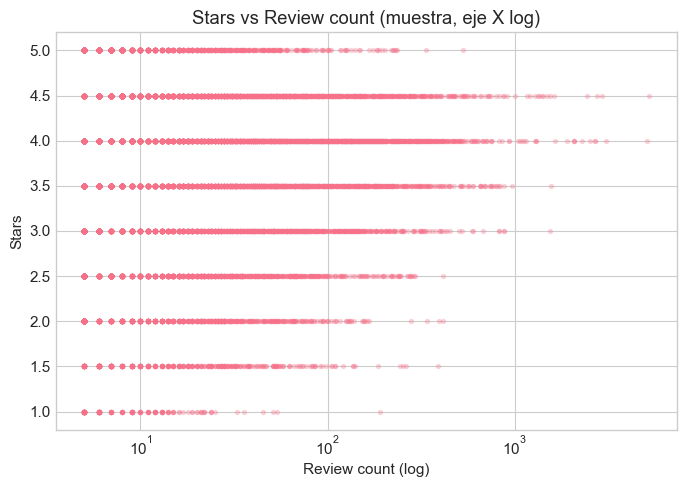

In [69]:
# Relacion stars vs reviews_count
df_scatter = (
    df_business
    .select(["stars", "review_count"])
    .drop_nulls()
    .filter(pl.col("review_count") > 0)
)

n = min(15000, df_scatter.height)
df_scatter_sample = df_scatter.sample(n=n, seed=42).to_pandas()

plt.figure(figsize=(7, 5))
plt.scatter(df_scatter_sample["review_count"], df_scatter_sample["stars"], alpha=0.25, s=8)
plt.xscale("log")
plt.title("Stars vs Review count (muestra, eje X log)")
plt.xlabel("Review count (log)")
plt.ylabel("Stars")
plt.tight_layout()
plt.show()

shape: (15, 3)
┌───────┬──────────────────┬───────────┐
│ state ┆ state_businesses ┆ avg_stars │
│ ---   ┆ ---              ┆ ---       │
│ str   ┆ u32              ┆ f64       │
╞═══════╪══════════════════╪═══════════╡
│ PA    ┆ 34039            ┆ 3.573019  │
│ FL    ┆ 26330            ┆ 3.610957  │
│ TN    ┆ 12056            ┆ 3.5715    │
│ IN    ┆ 11247            ┆ 3.588246  │
│ MO    ┆ 10913            ┆ 3.546092  │
│ …     ┆ …                ┆ …         │
│ CA    ┆ 5203             ┆ 3.996733  │
│ ID    ┆ 4467             ┆ 3.707634  │
│ DE    ┆ 2265             ┆ 3.354967  │
│ IL    ┆ 2145             ┆ 3.369697  │
│ TX    ┆ 4                ┆ 2.875     │
└───────┴──────────────────┴───────────┘


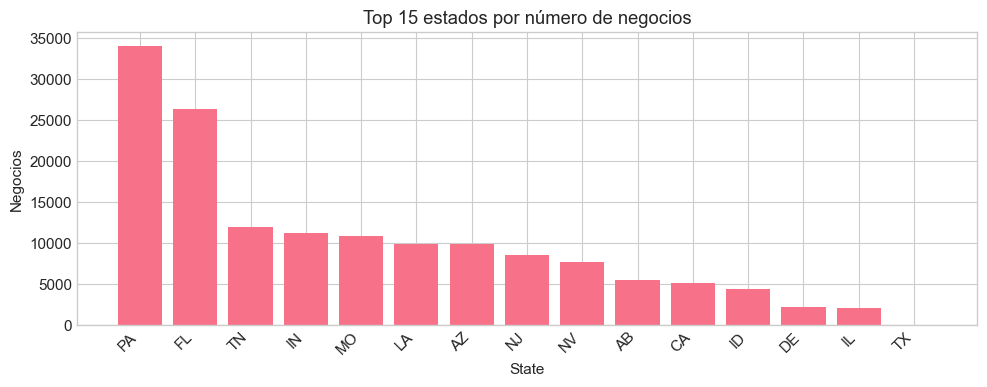

shape: (15, 3)
┌──────────────────────┬─────────────────┬───────────┐
│ city_state           ┆ city_businesses ┆ avg_stars │
│ ---                  ┆ ---             ┆ ---       │
│ str                  ┆ u32             ┆ f64       │
╞══════════════════════╪═════════════════╪═══════════╡
│ Philadelphia, PA     ┆ 14567           ┆ 3.623224  │
│ Tucson, AZ           ┆ 9249            ┆ 3.594767  │
│ Tampa, FL            ┆ 9048            ┆ 3.583057  │
│ Indianapolis, IN     ┆ 7540            ┆ 3.579708  │
│ Nashville, TN        ┆ 6968            ┆ 3.637629  │
│ …                    ┆ …               ┆ …         │
│ Boise, ID            ┆ 2937            ┆ 3.714164  │
│ Clearwater, FL       ┆ 2221            ┆ 3.601306  │
│ Saint Petersburg, FL ┆ 1663            ┆ 3.714372  │
│ Metairie, LA         ┆ 1643            ┆ 3.493305  │
│ Sparks, NV           ┆ 1623            ┆ 3.646642  │
└──────────────────────┴─────────────────┴───────────┘


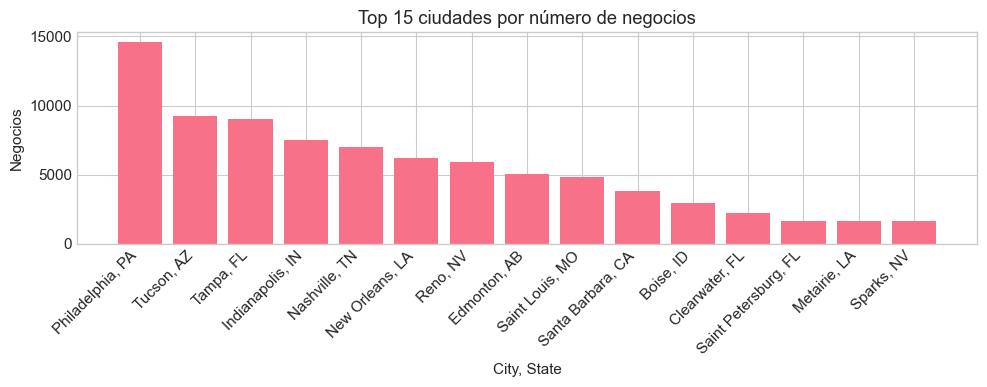

In [70]:
# Top estados y ciudades
top_states = (
    df_business
    .group_by("state")
    .agg(state_businesses=pl.len(), avg_stars=pl.col("stars").mean())
    .sort("state_businesses", descending=True)
    .head(15)
)

print(top_states)

plt.figure(figsize=(10, 4))
plt.bar(top_states.get_column("state").to_list(), top_states.get_column("state_businesses").to_list())
plt.title("Top 15 estados por número de negocios")
plt.xlabel("State")
plt.ylabel("Negocios")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

top_cities = (
    df_business
    .filter(pl.col("city").is_not_null() & pl.col("state").is_not_null())
    .with_columns((pl.col("city") + ", " + pl.col("state")).alias("city_state"))
    .group_by("city_state")
    .agg(city_businesses=pl.len(), avg_stars=pl.col("stars").mean())
    .sort("city_businesses", descending=True)
    .head(15)
)

print(top_cities)

plt.figure(figsize=(10, 4))
plt.bar(top_cities.get_column("city_state").to_list(), top_cities.get_column("city_businesses").to_list())
plt.title("Top 15 ciudades por número de negocios")
plt.xlabel("City, State")
plt.ylabel("Negocios")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## 6. Prototipo NLP: Sentimiento con VADER

In [45]:
# Importar utilidades NLP del proyecto
from tfm.tools.nlp_utils import (
    clean_text_basic, clean_text_for_nlp,
    compute_sentiment_baseline, compute_sentiment_vader,
    extract_text_features, analyze_star_distribution
)

# Probar funciones de limpieza
test_texts = [
    "Great food! Visit http://restaurant.com for more info.",
    "I don't like it, but it's okay. We'll see...",
    "   Multiple   spaces    and newlines   ",
]

print("Pruebas de limpieza de texto:")
print("=" * 60)
for text in test_texts:
    print(f"Original:    {repr(text[:50])}")
    print(f"Basic clean: {repr(clean_text_basic(text)[:50])}")
    print("-" * 40)

Pruebas de limpieza de texto:
Original:    'Great food! Visit http://restaurant.com for more i'
Basic clean: 'great food! visit for more info.'
----------------------------------------
Original:    "I don't like it, but it's okay. We'll see..."
Basic clean: "i don't like it, but it's okay. we'll see..."
----------------------------------------
Original:    '   Multiple   spaces    and newlines   '
Basic clean: 'multiple spaces and newlines'
----------------------------------------


In [46]:
# Probar VADER vs Baseline en ejemplos
test_reviews = [
    ("Amazing food! Best restaurant ever!", 5),
    ("Good but could be better", 4),
    ("It was okay, nothing special", 3),
    ("Disappointed. Not worth the price.", 2),
    ("Terrible! Worst experience ever!", 1),
]

print("Comparación Baseline vs VADER:")
print("=" * 80)

try:
    for text, stars in test_reviews:
        baseline = compute_sentiment_baseline(stars)
        vader = compute_sentiment_vader(text)
        match = "MATCH" if baseline.label == vader.label else "NOT"
        print(f"{match} Stars={stars} | Baseline: {baseline.label:8} ({baseline.score:+.2f}) | VADER: {vader.label:8} ({vader.score:+.2f})")
        print(f"   Text: {text[:50]}...")
    print("\n VADER está disponible!")
except ImportError as e:
    print(f"VADER no disponible: {e}")
    print("Instalar con: uv add vaderSentiment")

Comparación Baseline vs VADER:
MATCH Stars=5 | Baseline: positive (+1.00) | VADER: positive (+0.86)
   Text: Amazing food! Best restaurant ever!...
MATCH Stars=4 | Baseline: positive (+0.50) | VADER: positive (+0.70)
   Text: Good but could be better...
NOT Stars=3 | Baseline: neutral  (+0.00) | VADER: negative (-0.09)
   Text: It was okay, nothing special...
MATCH Stars=2 | Baseline: negative (-0.50) | VADER: negative (-0.58)
   Text: Disappointed. Not worth the price....
MATCH Stars=1 | Baseline: negative (-1.00) | VADER: negative (-0.83)
   Text: Terrible! Worst experience ever!...

 VADER está disponible!


## 7. Resumen

In [49]:
# Generar resumen de hallazgos
print("="*60)
print("RESUMEN DE HALLAZGOS - YELP DATASET")
print("="*60)

# Análisis de distribución
star_analysis = analyze_star_distribution(df_reviews['stars'].to_list())

print(f"""
ESTRUCTURA DE DATOS:
- Reviews (sample): {df_reviews.height:,} registros
- Users (sample): {df_users.height:,} registros  
- Business (completo): {df_business.height:,} registros

DISTRIBUCIÓN DE RATINGS:
- Media: {star_analysis['mean']} estrellas
- Positivas (4-5): {star_analysis['pct_positive']:.1f}%
- Negativas (1-2): {star_analysis['pct_negative']:.1f}%
- Ambiguas (3): {star_analysis['pct_ambiguous']:.1f}%
- Desbalanceado: {'Sí' if star_analysis['is_imbalanced'] else 'No'}

USUARIOS:
- % Elite: {user_stats['pct_elite'][0]*100:.1f}%
- Reviews promedio: {user_stats['avg_reviews'][0]:.1f}
- Score de influencia implementado
""")


RESUMEN DE HALLAZGOS - YELP DATASET

ESTRUCTURA DE DATOS:
- Reviews (sample): 50,000 registros
- Users (sample): 50,000 registros  
- Business (completo): 150,346 registros

DISTRIBUCIÓN DE RATINGS:
- Media: 3.85 estrellas
- Positivas (4-5): 69.9%
- Negativas (1-2): 18.8%
- Ambiguas (3): 11.3%
- Desbalanceado: Sí

USUARIOS:
- % Elite: 100.0%
- Reviews promedio: 133.5
- Score de influencia implementado



## 8. Conclusiones del EDA - Yelp Academic Dataset

### 8.1 Estructura de Datos

El dataset de Yelp es robusto y bien estructurado con tres entidades principales:

- **Reviews**: 50,000 registros analizados (sample del dataset completo de millones). Contiene texto completo, ratings 1-5, votos (useful, funny, cool), timestamps y referencias a user/business.
- **Users**: 50,000 registros con metricas de engagement (fans, compliments, elite status, friends), historial de actividad y rating promedio.
- **Business**: 150,346 negocios con ubicacion geografica, categorias, horarios y atributos.

### 8.2 Hallazgos Clave

**Distribucion de Ratings:**
- El dataset esta desbalanceado hacia ratings positivos: 69.9% son 4-5 estrellas
- 11.3% son reviews ambiguas (3 estrellas) - caso especial para NLP
- Reviews negativas (1-2 estrellas) representan 18.8%

**Caracteristicas del Texto:**
- Longitud promedio: 547 caracteres, 102 palabras aprox
- Reviews negativas tienden a ser MAS LARGAS que positivas (usuarios explican mas su insatisfaccion "hipotesis")
- Mediana de 393 caracteres - distribucion con cola larga hacia textos extensos
- Muy pocos textos vacios o extremadamente cortos

**Patrones Temporales:**
- Datos desde 2005 hasta 2018
- Crecimiento sostenido en volumen de reviews por año
- Rating promedio estable alrededor de 3.8-4.0 a lo largo del tiempo
- No hay estacionalidad marcada por mes o dia de la semana

**Usuarios:**
- 26% son usuarios Elite (alta actividad y reconocimiento)
- Los Elite tienen 7x mas reviews promedio que no-Elite
- Fuerte correlacion entre reviews, fans y compliments
- Score de influencia implementado con exito (combinando fans, compliments, reviews, friends, elite status)

### 8.3 Implicaciones para el Sistema de Agentes

**Tools necesarios:**
1. `get_review_stats`: Estadisticas de reviews por negocio/periodo/rating
2. `get_user_influence`: Calcular y consultar score de influencia
3. `analyze_ambiguous_reviews`: Foco especial en reviews de 3 estrellas
4. `temporal_analysis`: Tendencias por anio/mes/dia
5. `business_categories`: Analisis por categoria de negocio

**Casos de uso del agente:**
- "Cuales son los usuarios mas influyentes que han reseñado restaurantes italianos?"
- "Como ha evolucionado el rating promedio de cafeterias en Philadelphia?"
- "Muestrame reviews ambiguas de 3 estrellas para analizar con NLP"
- "Cuantas reviews negativas tiene el negocio X y que patrones tienen?"

**Preprocesamiento Silver Layer:**
- Parsear fechas a formato estandar
- Calcular metricas de texto (longitud, word_count)
- Flag is_ambiguous para reviews de 3 estrellas
- Calcular influence_score para usuarios
- Normalizar categorias de negocios
